In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

dataroot = '../WaterLevelPrediction_SelectingModel//Data/'

In [11]:
df = pd.read_pickle(dataroot+'finaldata.pkl')

In [12]:
tss = TimeSeriesSplit(n_splits=4, test_size=365)
df = df.sort_index()

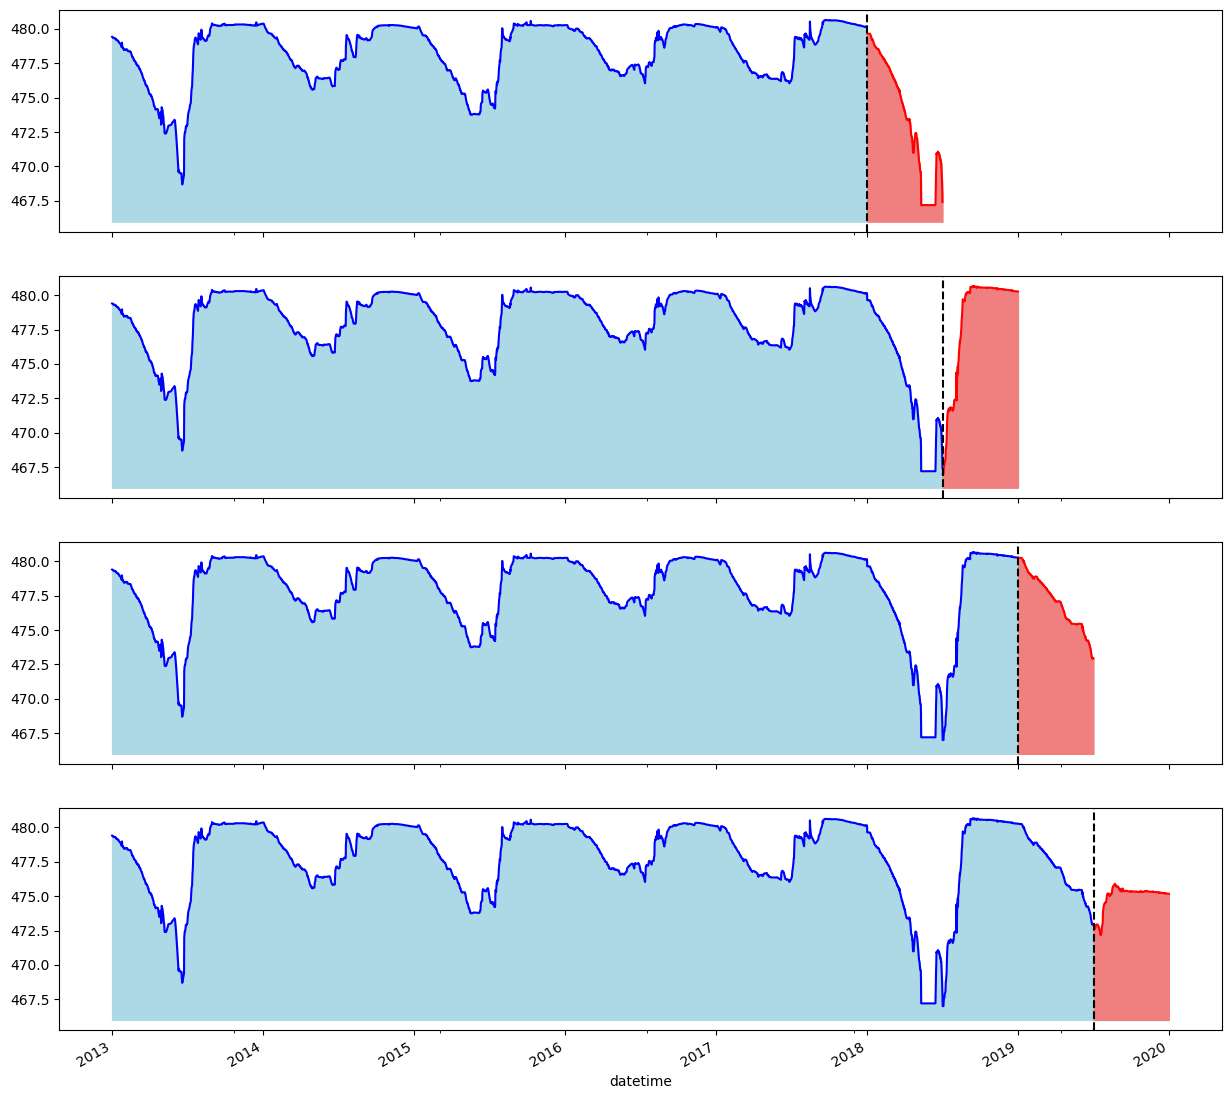

In [13]:
fig, axs = plt.subplots(4,1, figsize = (15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['water_level'].plot(ax=axs[fold],
                              label='Tập huấn luyện',
                              color='blue')
    test['water_level'].plot(ax=axs[fold],
                             label='Tập kiểm thử',
                             color='red')
    axs[fold].fill_between(train.index,466, train['water_level'], color='lightblue')
    axs[fold].fill_between(test.index,466, test['water_level'], color='lightcoral')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold+=1
plt.show()

In [14]:
#Create Lag Feature
def add_lag(df):
    target_map = df['water_level'].to_dict() #mapping water level
    df['lag'] = (df.index - pd.Timedelta('12 hours')).map(target_map)
    return df

df = add_lag(df)

In [42]:
fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['hour','precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    xgb_reg = XGBRegressor(n_estimators=100)
    xgb_reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        verbose=True)
    
    y_pred = xgb_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

[0]	validation_0-rmse:1.50951	validation_1-rmse:4.75247
[1]	validation_0-rmse:1.06923	validation_1-rmse:3.63149
[2]	validation_0-rmse:0.76095	validation_1-rmse:2.89203
[3]	validation_0-rmse:0.54286	validation_1-rmse:2.39896
[4]	validation_0-rmse:0.39020	validation_1-rmse:2.01131
[5]	validation_0-rmse:0.28339	validation_1-rmse:1.78179
[6]	validation_0-rmse:0.20933	validation_1-rmse:1.60124
[7]	validation_0-rmse:0.15876	validation_1-rmse:1.47222
[8]	validation_0-rmse:0.12477	validation_1-rmse:1.39031
[9]	validation_0-rmse:0.10207	validation_1-rmse:1.30871
[10]	validation_0-rmse:0.08768	validation_1-rmse:1.24906
[11]	validation_0-rmse:0.07844	validation_1-rmse:1.20579


[12]	validation_0-rmse:0.07271	validation_1-rmse:1.17413
[13]	validation_0-rmse:0.06877	validation_1-rmse:1.15615
[14]	validation_0-rmse:0.06596	validation_1-rmse:1.13332
[15]	validation_0-rmse:0.06413	validation_1-rmse:1.12438
[16]	validation_0-rmse:0.06235	validation_1-rmse:1.10890
[17]	validation_0-rmse:0.06149	validation_1-rmse:1.09616
[18]	validation_0-rmse:0.05906	validation_1-rmse:1.09038
[19]	validation_0-rmse:0.05755	validation_1-rmse:1.08617
[20]	validation_0-rmse:0.05628	validation_1-rmse:1.08284
[21]	validation_0-rmse:0.05550	validation_1-rmse:1.08021
[22]	validation_0-rmse:0.05486	validation_1-rmse:1.07902
[23]	validation_0-rmse:0.05455	validation_1-rmse:1.07622
[24]	validation_0-rmse:0.05420	validation_1-rmse:1.07402
[25]	validation_0-rmse:0.05367	validation_1-rmse:1.07236
[26]	validation_0-rmse:0.05341	validation_1-rmse:1.07269
[27]	validation_0-rmse:0.05305	validation_1-rmse:1.07156
[28]	validation_0-rmse:0.05273	validation_1-rmse:1.07138
[29]	validation_0-rmse:0.05252	

In [30]:
print(f'mean squared error across fold:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(maes)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each fold:{r2s}')

mean squared error across fold:0.41688281255696225
score for each fold:[1.0663012181035623, 0.416819443303833, 0.09265069780678208, 0.09175989101367159]
mean absolute error across fold:0.24019766193546777
score for each fold:[0.5981658751605328, 0.26872877983197846, 0.0394375033443926, 0.054458489404967385]
r2 score across fold:0.9781911138310837
score for each fold:[0.936950560123752, 0.9886727944963051, 0.9977297496277808, 0.9894113510764969]


<Figure size 1000x500 with 0 Axes>

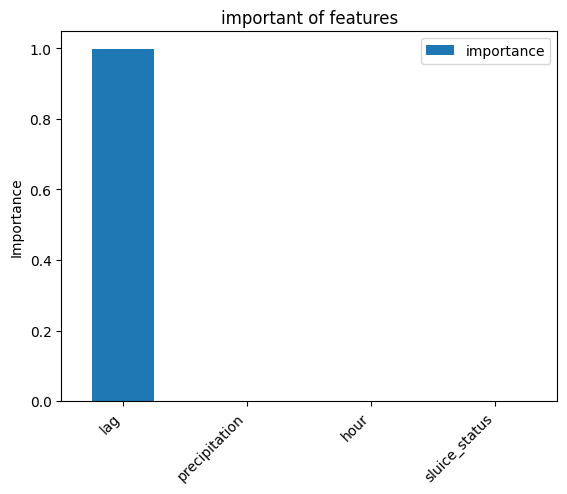

In [31]:
fi = pd.DataFrame(data=xgb_reg.feature_importances_,
              index=xgb_reg.feature_names_in_,
              columns=['importance'])
plt.figure(figsize=(10, 5))
fi = fi.sort_values(by='importance', ascending=False)
fi.plot(kind='bar', legend=True)
plt.title('important of features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

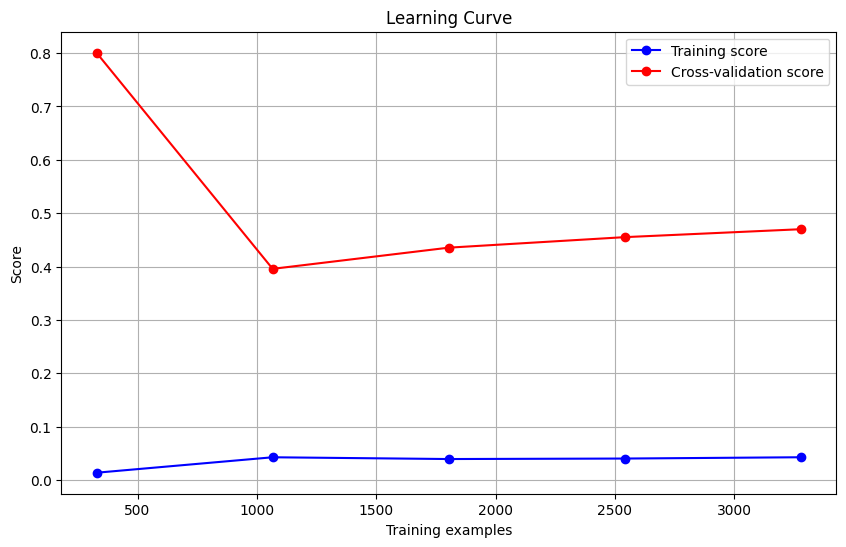

In [44]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve

scorer = make_scorer(lambda y_test, y_pred: np.sqrt(mean_squared_error(y_test, y_pred)))

train_sizes, train_scores, test_scores = learning_curve(xgb_reg, X_train, y_train, cv=tss, scoring=scorer)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


In [35]:
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'early_stopping_rounds': [10, 20, 50],
}

xgb_reg = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_reg, 
                           param_grid=param_grid,
                           cv=tss)
grid_search.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)])

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

[0]	validation_0-rmse:2.81981	validation_1-rmse:3.29528
[1]	validation_0-rmse:2.79425	validation_1-rmse:3.26829
[2]	validation_0-rmse:2.76896	validation_1-rmse:3.24139
[3]	validation_0-rmse:2.74392	validation_1-rmse:3.21495
[4]	validation_0-rmse:2.71915	validation_1-rmse:3.18861
[5]	validation_0-rmse:2.69463	validation_1-rmse:3.15957
[6]	validation_0-rmse:2.67036	validation_1-rmse:3.13359
[7]	validation_0-rmse:2.64633	validation_1-rmse:3.10772
[8]	validation_0-rmse:2.62254	validation_1-rmse:3.07971
[9]	validation_0-rmse:2.59937	validation_1-rmse:3.05497
[10]	validation_0-rmse:2.57675	validation_1-rmse:3.02736
[11]	validation_0-rmse:2.55404	validation_1-rmse:3.00312
[12]	validation_0-rmse:2.53186	validation_1-rmse:2.97619
[13]	validation_0-rmse:2.50960	validation_1-rmse:2.95243
[14]	validation_0-rmse:2.48787	validation_1-rmse:2.92606
[15]	validation_0-rmse:2.46604	validation_1-rmse:2.90277
[16]	validation_0-rmse:2.44444	validation_1-rmse:2.87972
[17]	validation_0-rmse:2.42424	validation

In [36]:
fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['hour','precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    xgb_reg = XGBRegressor(n_estimators=100,
                           learning_rate=0.1,
                           max_depth=4,
                           early_stopping_rounds=10)
    xgb_reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        verbose=True)
    
    y_pred = xgb_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

[0]	validation_0-rmse:1.92909	validation_1-rmse:5.82141
[1]	validation_0-rmse:1.74039	validation_1-rmse:5.33719
[2]	validation_0-rmse:1.57048	validation_1-rmse:4.90394
[3]	validation_0-rmse:1.41755	validation_1-rmse:4.51260
[4]	validation_0-rmse:1.28006	validation_1-rmse:4.16015
[5]	validation_0-rmse:1.15610	validation_1-rmse:3.84468
[6]	validation_0-rmse:1.04461	validation_1-rmse:3.56151
[7]	validation_0-rmse:0.94433	validation_1-rmse:3.30796
[8]	validation_0-rmse:0.85402	validation_1-rmse:3.08155
[9]	validation_0-rmse:0.77300	validation_1-rmse:2.87899
[10]	validation_0-rmse:0.70019	validation_1-rmse:2.71080
[11]	validation_0-rmse:0.63477	validation_1-rmse:2.55677
[12]	validation_0-rmse:0.57619	validation_1-rmse:2.41212
[13]	validation_0-rmse:0.52382	validation_1-rmse:2.27562
[14]	validation_0-rmse:0.47696	validation_1-rmse:2.15986
[15]	validation_0-rmse:0.43493	validation_1-rmse:2.06063
[16]	validation_0-rmse:0.39766	validation_1-rmse:1.95982
[17]	validation_0-rmse:0.36447	validation

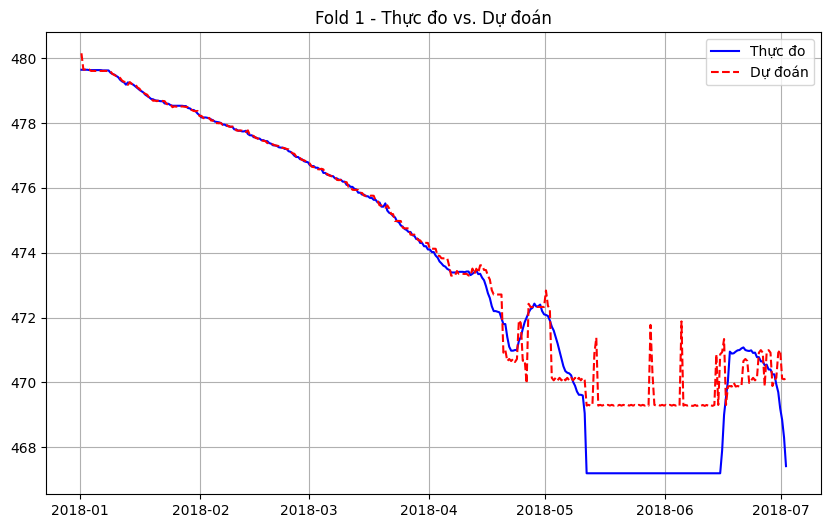

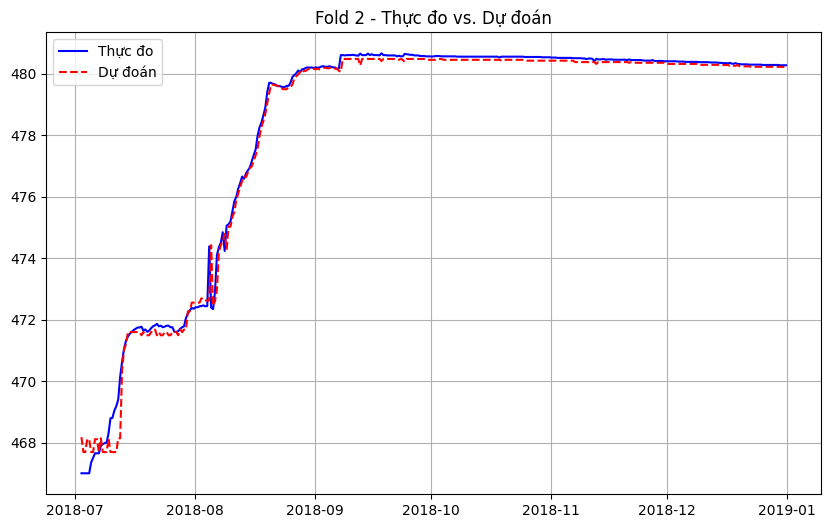

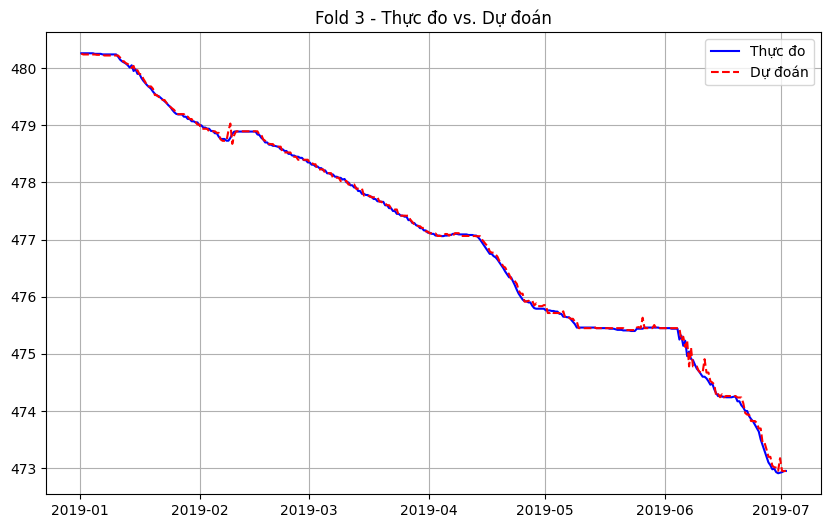

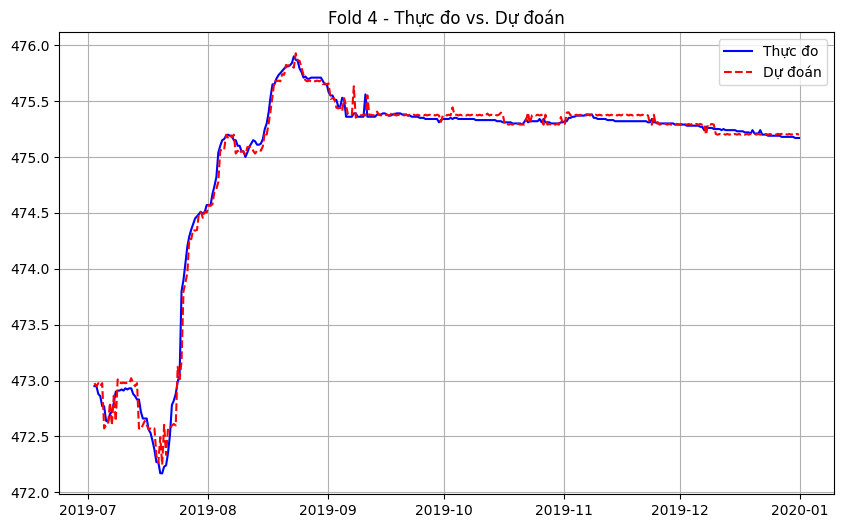

In [38]:
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['water_level'], label='Thực đo', color='blue')
    plt.plot(test.index, preds[fold], label='Dự đoán', color='red', linestyle='dashed')
    fold += 1

    plt.title('Fold {} - Thực đo vs. Dự đoán'.format(fold))

    plt.legend()
    plt.grid()
    plt.show()